In [1]:
from make_ewma_features_df import *
from useful_funcs import *
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

# Fitting model

In [2]:
gw_df = get_dfs(25, 38)
ewma_merge_lag = make_ewma_features_df(gw_df, 25, 0.4).dropna()

In [3]:
ewma_merge_lag.columns

Index(['full_name', 'gw', 'total_points', 'position', 'team', 'opponent_team',
       'assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
       'goals_scored', 'influence', 'creativity', 'threat', 'ict_index',
       'minutes', 'ewma_total_points', 'opponent_team_name', 'ewma_team_goals',
       'ewma_team_points', 'nw_total_points', 'nw_opponent',
       'ewma_nw_opponent_goals', 'ewma_nw_opponent_points'],
      dtype='object')

In [4]:
model_dict = {}
for pos in ['FWD', 'MID', 'DEF', 'GK']:
    ewma_merge_lag_pos = ewma_merge_lag.query('position==@pos').set_index(['full_name', 'gw'])
    X = ewma_merge_lag_pos[[
        'assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
        'goals_scored', 'influence', 'creativity', 'threat', 'ict_index',
        'minutes', 'ewma_total_points', 'ewma_team_goals', 'ewma_team_points',
        'ewma_nw_opponent_goals', 'ewma_nw_opponent_points']]

    y = ewma_merge_lag_pos['nw_total_points']

    model = LinearRegression()
    model.fit(X, y)

    model_dict[pos] = model

# Testing on last season

In [5]:
pred_dfs = []
for pos in ['FWD', 'MID', 'DEF', 'GK']:
    gw5_pos = ewma_merge_lag.query('gw==5 and position==@pos').set_index(['full_name', 'gw'])

    pos_pred = model_dict[pos].predict(gw5_pos[['assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
        'goals_scored', 'influence', 'creativity', 'threat', 'ict_index',
        'minutes', 'ewma_total_points', 'ewma_team_goals', 'ewma_team_points',
        'ewma_nw_opponent_goals', 'ewma_nw_opponent_points']])

    gw5_pos['pred'] = pos_pred
    pred_dfs.append(gw5_pos)
    
pred_df = pd.concat(pred_dfs)


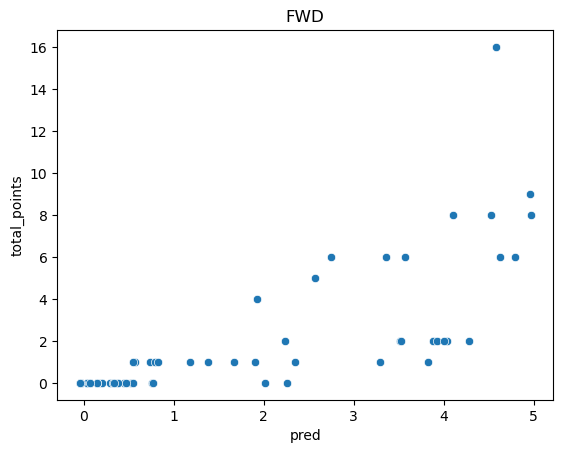

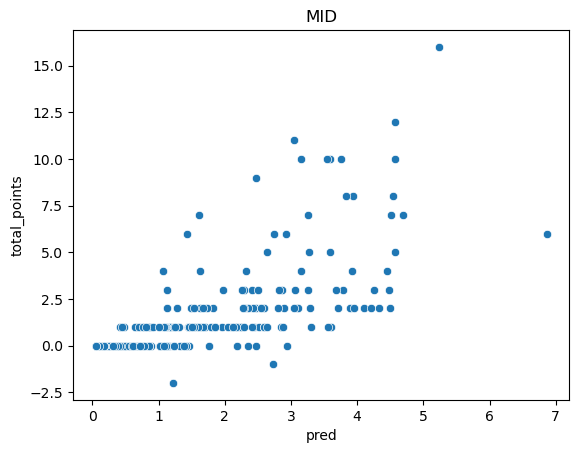

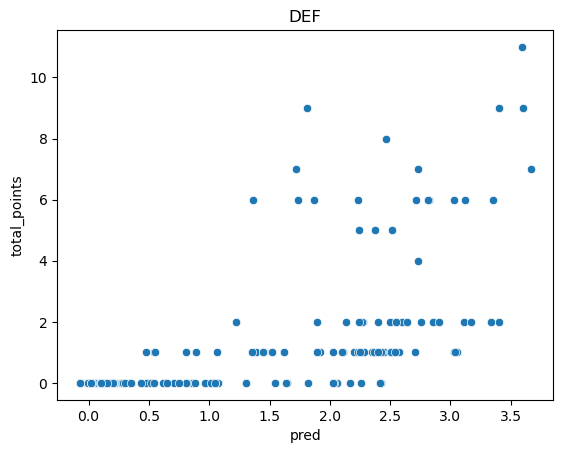

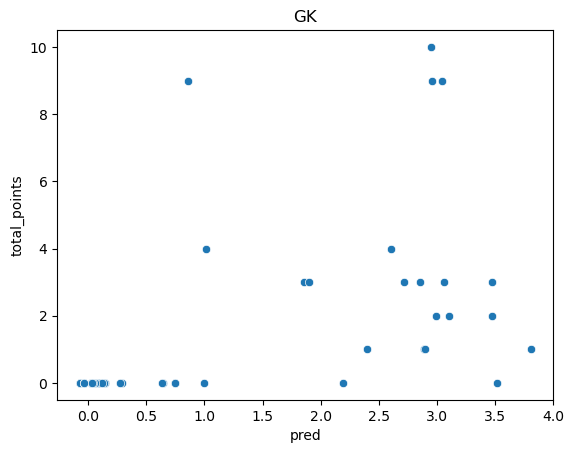

In [6]:
for pos in ['FWD', 'MID', 'DEF', 'GK']:
    plt.figure()
    sns.scatterplot(data=pred_df.query('position==@pos'), y='total_points', x='pred').set(title=pos)

# Applying to this season's data

In [7]:
import requests, json

In [8]:
# gw_dfs = []

# for gw in range(38):
#     event_id = gw + 1
#     url = f'https://fantasy.premierleague.com/api/event/{event_id}/live/'
#     response = requests.get(url)
#     if response.status_code != 200:
#         raise Exception("Response was code " + str(response.status_code))
#     gw1 = json.loads(response.text)

#     # Ensure each 'stats' is a list
#     elements = gw1['elements']
#     for el in elements:
#         if isinstance(el.get('stats'), dict):
#             el['stats'] = [el['stats']]

#     gw_df = pd.json_normalize(
#         elements,
#         record_path=['stats'],
#         meta=['id', 'explain', 'modified']
#     )

#     gw_df['gw'] = event_id
#     gw_dfs.append(gw_df)

# gw_all = pd.concat(gw_dfs).reset_index(drop=True)

## Trying to do it myself

In [9]:
gw_df = get_dfs(26, 4)

In [10]:
alpha = 0.4

gw_df = get_dfs(26, 4)
gw_df = add_goals(gw_df)
gw_df = clean_name_in_index(gw_df)

player_value_cols = ['assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded', 'goals_scored',
                    'influence', 'creativity', 'threat', 'ict_index', 'minutes', 'total_points']
merge_cols_players = ['full_name', 'gw', 'total_points', 'position','team','opponent_team']
ewma_gw_df_players = ewma(gw_df, 'full_name', player_value_cols, alpha, {'total_points': 'ewma_total_points'}, merge_cols_players)

gw_df_teams = get_teams_df(gw_df)
team_value_cols = ['team_goals', 'team_points']
merge_cols_teams = ['team', 'gw']
ewma_gw_df_teams = ewma(gw_df_teams, 'team', team_value_cols, alpha, {'team_goals': 'ewma_team_goals',
                                                                      'team_points': 'ewma_team_points'}, merge_cols_teams)

In [34]:
teamcode_dict = get_teamcodes(26)

ewma_gw_df_opponent_team = ewma_gw_df_teams.rename(columns={'team': 'opponent_team_name', 
                                                            'ewma_team_goals': 'ewma_nw_opponent_goals',
                                                            'ewma_team_points': 'ewma_nw_opponent_points'})
ewma_gw_df = ewma_gw_df_players.merge(ewma_gw_df_teams, on=['team', 'gw'], how='left')

In [36]:
ewma_gw_df.columns

Index(['full_name', 'gw', 'total_points', 'position', 'team', 'opponent_team',
       'assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
       'goals_scored', 'influence', 'creativity', 'threat', 'ict_index',
       'minutes', 'ewma_total_points', 'ewma_team_goals', 'ewma_team_points'],
      dtype='object')

In [12]:
fixtures_url = 'https://fantasy.premierleague.com/api/fixtures/'
r = requests.get(fixtures_url).json()
fixtures_df = pd.json_normalize(r)

In [13]:
fixtures_df_gw = fixtures_df.query('event==4+1')

h_teams = fixtures_df_gw['team_h'].map(teamcode_dict)
a_teams = fixtures_df_gw['team_a'].map(teamcode_dict)
fixture_dict = {**dict(zip(h_teams, a_teams)), **dict(zip(a_teams, h_teams))}

In [14]:
ewma_gw_df['nw_opponent_team_name'] = ewma_gw_df_players['team'].map(fixture_dict)

In [15]:
ewma_gw_df_teams_merge = ewma_gw_df_teams.query('gw==4')[['team', 'ewma_team_goals', 'ewma_team_points']]
ewma_gw_df_teams_merge.rename(columns={'team': 'nw_opponent_team_name',
                                     'ewma_team_goals': 'ewma_nw_opponent_goals', 
                                     'ewma_team_points': 'ewma_nw_opponent_points'}, inplace=True)
ewma_gw_df = ewma_gw_df.merge(ewma_gw_df_teams_merge, on='nw_opponent_team_name', how='left')

In [16]:
# team_goal_dict = dict(
#     zip(ewma_gw_df_teams.query('gw==4')['team'], ewma_gw_df_teams.query('gw==4')['ewma_team_goals']))
# team_goal_dict = dict(
#     zip(ewma_gw_df_teams.query('gw==4')['team'], ewma_gw_df_teams.query('gw==4')['ewma_team_goals']))

In [17]:
# ewma_gw_df['ewma_nw_opponent_goals'] = ewma_gw_df['nw_opponent_team_name'].map(team_goal_dict)

In [18]:
pred_dfs = []
for pos in ['FWD', 'MID', 'DEF', 'GK']:
    gw_pos = ewma_gw_df.query('gw==4 and position==@pos').set_index(['full_name', 'gw'])

    pos_pred = model_dict[pos].predict(gw_pos[['assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
        'goals_scored', 'influence', 'creativity', 'threat', 'ict_index',
        'minutes', 'ewma_total_points', 'ewma_team_goals', 'ewma_team_points',
        'ewma_nw_opponent_goals', 'ewma_nw_opponent_points']])

    gw_pos['pred'] = pos_pred
    pred_dfs.append(gw_pos)
    
pred_df = pd.concat(pred_dfs)

In [19]:
league_url = 'https://draft.premierleague.com/api/league/19188/element-status'
r = requests.get(league_url).json()
ownership_df = pd.json_normalize(r['element_status'])

In [20]:
url = 'https://draft.premierleague.com/api/bootstrap-static'
req = requests.get(url).json()
players_df = pd.json_normalize(req['elements'])

players_df['full_name'] = players_df['first_name'] + ' ' + players_df['second_name']
players_df = clean_name_in_index(players_df.set_index('full_name'))

merge_name_df = players_df[['id', 'full_name']]

In [21]:
ownership_df_name = ownership_df.merge(merge_name_df, how='left', left_on='element', right_on='id')
ownership_df_to_merge = ownership_df_name[['full_name', 'owner']]

In [22]:
pred_df_owners = pred_df.merge(ownership_df_to_merge, on='full_name')

In [23]:
pred_df_simple = pred_df_owners[['full_name', 'ewma_total_points', 'minutes', 'position', 'pred', 'owner']]

In [24]:
pred_df_simple_sorted = pred_df_simple.sort_values(by='pred', ascending=False)

In [25]:
pred_df_simple_sorted.head(50)

,full_name,ewma_total_points,minutes,position,pred,owner
23,erling_haaland,10.456,84.512,FWD,5.528059,88376.0
125,bryan_mbeumo,3.920,90.000,MID,4.949267,93330.0
174,enzo_fernandez,6.568,87.408,MID,4.933406,NaN
53,nick_woltemade,9.000,64.000,FWD,4.847397,93330.0
104,antoine_semenyo,9.784,90.000,MID,4.847371,87737.0
71,viktor_gyokeres,4.584,74.104,FWD,4.788860,88376.0
141,cody_gakpo,4.872,90.000,MID,4.736668,85076.0
213,iliman_ndiaye,5.264,86.112,MID,4.700851,88376.0
321,mohamed_salah,6.768,90.000,MID,4.684597,93330.0
29,hugo_ekitike,4.952,73.832,FWD,4.652663,85076.0


In [26]:
pred_df_simple_sorted.query('position=="DEF"').sort_values('pred', ascending=False).head(50)

,full_name,ewma_total_points,minutes,position,pred,owner
642,veljko_milosavljevic,4.000,90.000,DEF,4.224214,NaN
497,james_tarkowski,5.936,90.000,DEF,3.901215,88376.0
636,trevoh_chalobah,6.768,86.832,DEF,3.888376,85076.0
558,marcos_senesi_baron,6.288,90.000,DEF,3.874486,94654.0
506,joachim_andersen,5.728,90.000,DEF,3.873483,NaN
450,cristian_romero,7.584,90.000,DEF,3.838454,85076.0
521,jurrien_timber,7.136,70.776,DEF,3.637184,87737.0
473,gabriel_dos_santos_magalhaes,6.240,90.000,DEF,3.575874,87737.0
527,kieran_trippier,6.080,80.880,DEF,3.567211,88376.0
570,michael_keane,4.704,90.000,DEF,3.500525,NaN


In [27]:
pred_df_simple_sorted.query('owner==85646.0').sort_values('pred', ascending=False).head(50)

,full_name,ewma_total_points,minutes,position,pred,owner
322,mohammed_kudus,4.272,87.984,MID,4.460182,85646.0
220,jack_grealish,5.000,73.944,MID,4.425406,85646.0
33,jarrod_bowen,3.680,90.000,FWD,3.869732,85646.0
167,elliot_anderson,3.664,90.000,MID,3.648006,85646.0
675,david_raya_martin,5.904,90.000,GK,3.583315,85646.0
470,fabian_schar,6.512,88.560,DEF,3.455524,85646.0
640,tyrick_mitchell,5.928,90.000,DEF,3.134232,85646.0
64,rodrigo_muniz_carvalho,2.552,62.384,FWD,2.987190,85646.0
671,caoimhin_kelleher,1.976,90.000,GK,2.799868,85646.0
461,djed_spence,4.400,82.000,DEF,2.612291,85646.0


In [28]:
from itertools import product

def get_best_formation(pred_df):
    # Possible formation constraints
    gk = 1
    def_range = range(3, 6)   # 3 to 5 DEF
    mid_range = range(3, 6)   # 3 to 5 MID
    fwd_range = range(1, 4)   # 1 to 3 FWD

    best_total = -float('inf')
    best_formation = None
    best_team = None

    for d, m, f in product(def_range, mid_range, fwd_range):
        if gk + d + m + f == 11:
            formation = {'GK': gk, 'DEF': d, 'MID': m, 'FWD': f}
            team = []
            for pos, n in formation.items():
                team.extend(pred_df.query(f'position == "{pos}"').head(n).to_dict('records'))
            total_pred = sum(player['pred'] for player in team)
            if total_pred > best_total:
                best_total = total_pred
                best_formation = formation
                best_team = team

    best_11_df = pd.DataFrame(best_team)
    return best_formation, best_11_df.sort_values('pred', ascending=False)

In [29]:
owner_dict = {88376.0: 'Doug',
              93330.0: 'Marcus',
              87737.0: 'Will',
              85076.0: 'Lucas',
              85646.0: 'Dave',
              94654.0: 'Rory'  
              }

In [30]:
# Example usage:
for owner in pred_df_simple_sorted['owner'].dropna().unique():
    print(f"Owner: {owner_dict[owner]}")
    best_formation, best_11_df = get_best_formation(pred_df_simple_sorted.query('owner==@owner'))
    # print("Best formation:", best_formation)
    print(best_11_df['pred'].sum())

Owner: Doug
43.677309828771236
Owner: Marcus
40.95884254364487
Owner: Will
40.76601634533898
Owner: Lucas
42.22953381496061
Owner: Dave
36.66399651065278
Owner: Rory
39.53703983374478


In [31]:
best_formation, best_11_df = get_best_formation(pred_df_simple_sorted.query('owner==85646.0'))

best_11_df

,full_name,ewma_total_points,minutes,position,pred,owner
4,mohammed_kudus,4.272,87.984,MID,4.460182,85646.0
5,jack_grealish,5.000,73.944,MID,4.425406,85646.0
9,jarrod_bowen,3.680,90.000,FWD,3.869732,85646.0
6,elliot_anderson,3.664,90.000,MID,3.648006,85646.0
0,david_raya_martin,5.904,90.000,GK,3.583315,85646.0
1,fabian_schar,6.512,88.560,DEF,3.455524,85646.0
2,tyrick_mitchell,5.928,90.000,DEF,3.134232,85646.0
10,rodrigo_muniz_carvalho,2.552,62.384,FWD,2.987190,85646.0
3,djed_spence,4.400,82.000,DEF,2.612291,85646.0
7,brennan_johnson,3.664,44.872,MID,2.307831,85646.0
